In [14]:
from datetime import datetime

import pandas as pd
import plotly.graph_objects as go
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

## Preparación de datos

- Lectura de datasets
- Concatenar todas las tormentas y escorrentías
- Filtrar datos, cada 15 minutos
- Armar columnas de datos descriptores: mm caídos, mm acumulados en tiempos ***t-i***
- Visualizar

In [15]:
# rainfall & runoff dataset
rainfall = pd.read_csv("data/lluvia_R2.csv", sep=";", parse_dates=["datetime"], comment="#")
runoff = pd.read_csv("data/nivel_R5.csv", sep=";", parse_dates=["datetime"], comment="#")

In [16]:
# Fechas de tormentas, revisar: https://monitorreservasfe.streamlit.app/

# to convert from str to datetime
to_datetime = lambda date_str:datetime.strptime(date_str, "%Y-%m-%d %H:%M:%S")

# dates of storms
rainy_date = [{"ini": to_datetime("2023-05-18 00:00:00"), "end": to_datetime("2023-05-29 00:00:00")}, # 74.75 mm
          {"ini": to_datetime("2023-07-11 21:00:00"), "end": to_datetime("2023-07-13 00:00:00")}, #  8.00 mm
          {"ini": to_datetime("2023-09-03 12:00:00"), "end": to_datetime("2023-09-04 12:00:00")}, #  4.25 mm
          {"ini": to_datetime("2023-10-22 00:00:00"), "end": to_datetime("2023-10-23 12:00:00")}, # 99.75 mm
          {"ini": to_datetime("2023-10-27 18:00:00"), "end": to_datetime("2023-11-03 00:00:00")}, # 68.75 mm
         ]

In [17]:
# armo dos listas con los dataframes de cada lluvia y escorrentía en el rango de fechas
data_rainfall = []
data_runoff   = []
for a_date in rainy_date:
    date_ini = a_date["ini"]
    date_end = a_date["end"]
    # filtro lluvia en rango de fechas
    idx_rain = (rainfall.datetime >= date_ini) & (rainfall.datetime <= date_end)
    data_rainfall.append(rainfall[idx_rain])
    # filtro escorrentia en rango de fechas
    idx_runoff = (runoff.datetime >= date_ini) & (runoff.datetime <= date_end)
    data_runoff.append(runoff[idx_runoff])

In [18]:
# concatena dataframes en uno único
concatenated_rainfall = pd.concat(data_rainfall, axis=0).reset_index(drop=True) 
concatenated_runoff   = pd.concat(data_runoff, axis=0).reset_index(drop=True)

In [20]:
idx_negative = (concatenated_runoff.nivel < 0)
concatenated_runoff.loc[idx_negative, "nivel"] = 0

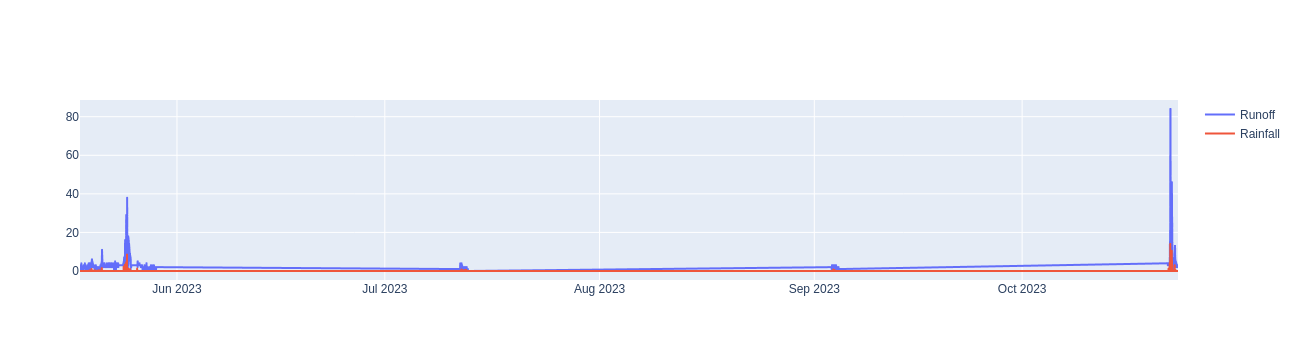

In [21]:
# plot para ver qué onda
fig = go.Figure()
fig.add_trace(go.Scattergl(x=concatenated_runoff.datetime, y=concatenated_runoff.nivel, name="Runoff"))
fig.add_trace(go.Scattergl(x=concatenated_rainfall.datetime, y=concatenated_rainfall.mm15min, name="Rainfall"))

In [22]:
# filtramos cada 15 minutos
rainfall_ready = concatenated_rainfall[(concatenated_rainfall['datetime'].dt.minute % 15 == 0)]
runoff_ready = concatenated_runoff[(concatenated_runoff['datetime'].dt.minute % 15 == 0)]

In [23]:
len(rainfall_ready)

1395

In [24]:
len(runoff_ready)

1395

In [25]:
rainfall_ready['Fecha_str'] = rainfall_ready['datetime'].dt.strftime('%Y-%m-%d %H:%M')
runoff_ready['Fecha_str'] = runoff_ready['datetime'].dt.strftime('%Y-%m-%d %H:%M')

/tmp/ipykernel_43565/3209999814.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_43565/3209999814.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [26]:
# Encuentra las fechas en df1 que no están en df2
fechas_no_encontradas = runoff_ready[~runoff_ready['Fecha_str'].isin(rainfall_ready['Fecha_str'])]

print(fechas_no_encontradas['Fecha_str'])

Series([], Name: Fecha_str, dtype: object)


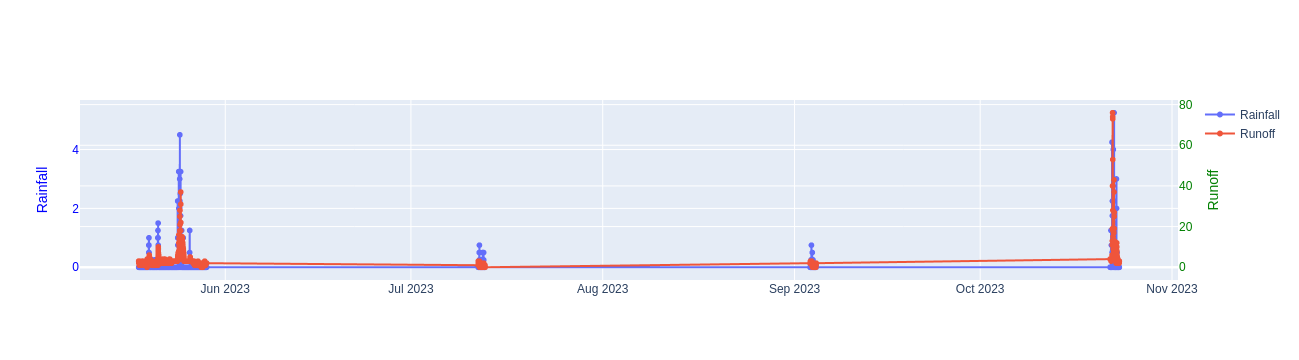

In [27]:
# plot para ver qué onda
fig = go.Figure()
fig.add_trace(go.Scattergl(x=rainfall_ready.Fecha_str, y=rainfall_ready.mm15min, mode="markers+lines", name="Rainfall"))
fig.add_trace(go.Scattergl(x=runoff_ready.Fecha_str,y=runoff_ready.nivel, mode="markers+lines", name="Runoff", yaxis="y2"))

fig.update_layout(yaxis=dict(title='Rainfall', titlefont=dict(color='blue'), tickfont=dict(color='blue')))
fig.update_layout(yaxis2=dict(title='Runoff', titlefont=dict(color='green'), tickfont=dict(color='green'), overlaying='y', side='right'))

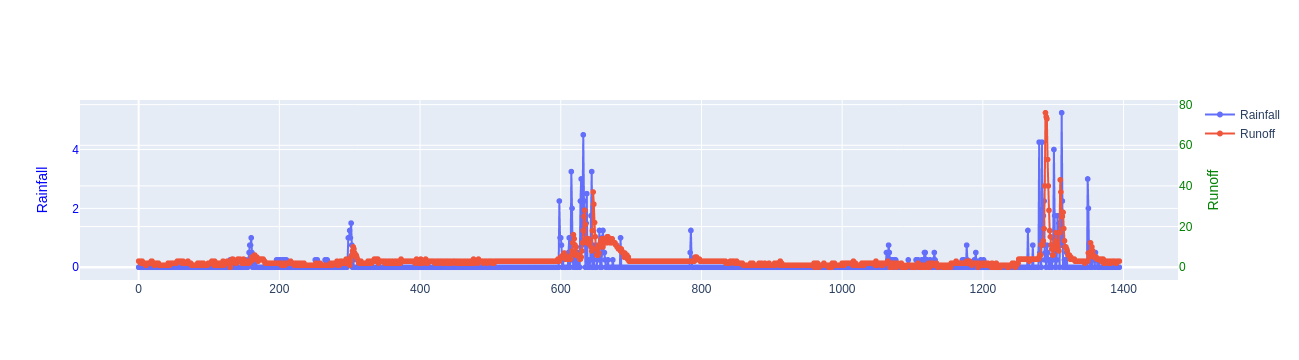

In [28]:
# plot para ver qué onda
fig = go.Figure()
fig.add_trace(go.Scattergl(y=rainfall_ready.mm15min, mode="markers+lines", name="Rainfall"))
fig.add_trace(go.Scattergl(y=runoff_ready.nivel, mode="markers+lines", name="Runoff", yaxis="y2"))

fig.update_layout(yaxis=dict(title='Rainfall', titlefont=dict(color='blue'), tickfont=dict(color='blue')))
fig.update_layout(yaxis2=dict(title='Runoff', titlefont=dict(color='green'), tickfont=dict(color='green'), overlaying='y', side='right'))

In [31]:
# renombro columas con mismo y guardo en CSV
rainfall_ready.columns = ['datetime_rainfall', 'cangilones', 'mm', 'mm15min', 'Fecha_str_rainfall']
runoff_ready.columns = ['datetime_runoff', 'bateria', 'nivel', 'dist', 'Fecha_str_runoff']

rainfall_ready.to_csv("data/rainfall_ready.csv", sep=";", index=False)
runoff_ready.to_csv("data/runoff_ready.csv", sep=";", index=False)

In [33]:
rain_data = open("data/rainfall_ready.csv").readlines()
runo_data = open("data/runoff_ready.csv").readlines()

dataset = open("data/dataset1.csv", "w")

for rain, runo in zip(rain_data, runo_data):
    ra = rain.strip()
    ru = runo.strip()
    line = f"{ra};{ru}\n"
    dataset.write(line)

dataset.close()

## Machine learning regressions
- Leer archivo `dataset1`
- Armar columnas extras para usar como entrada X
- Hacer regresiones

In [46]:
X = una_lluvia2[['mm15min']]  
y = un_runoff2['nivel']

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
k = 3  # Número de vecinos a considerar (ajusta según tus necesidades)
model = KNeighborsRegressor(n_neighbors=k)
model.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=3)

In [49]:
y_pred = model.predict(X_test)

In [50]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'R^2: {r2}')


MSE: 36.46560846560847
R^2: -2.5483965872315393
